In [ ]:
!pip install sdv

In [2]:
from sdv.tabular import CTGAN
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from pickle import dump, load

In [3]:
# https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data
sensor = pd.read_csv("sensor.csv")

# only keeping cols w high var in pca analysis + machine status
data = sensor[
    ["timestamp", "sensor_25", "sensor_11", "sensor_36", "sensor_34", "machine_status"]
]

In [4]:
# okay, what can our machine status be?

# data = data.convert_dtypes()
print(data.dtypes, "\n")
# i have no idea why i have to run this line twice for it to work.
data["timestamp"] = pd.to_datetime(data["timestamp"])

data.machine_status.unique()

timestamp          object
sensor_25         float64
sensor_11         float64
sensor_36         float64
sensor_34         float64
machine_status     object
dtype: object 



/tmp/ipykernel_364416/2577753386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [5]:
# okay, what can our machine status be?

# data = data.convert_dtypes()
print(data.dtypes, "\n")
# i have no idea why i have to run this line twice for it to work.
data["timestamp"] = pd.to_datetime(data["timestamp"])

data.machine_status.unique()

timestamp         datetime64[ns]
sensor_25                float64
sensor_11                float64
sensor_36                float64
sensor_34                float64
machine_status            object
dtype: object 



/tmp/ipykernel_364416/2577753386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp']= pd.to_datetime(data['timestamp'])


array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [6]:
data_around_failures = data.iloc[16000:26000]
len(data_around_failures)

10000

In [7]:
print(data_around_failures[data_around_failures.isna().any(axis=1)])

# we only have one row with NA, let's simply drop that.

data_around_failures.dropna(axis=0, inplace=True)

print(data_around_failures[data_around_failures.isna().any(axis=1)])

                timestamp  sensor_25  sensor_11  sensor_36  sensor_34  \
25112 2018-04-18 10:32:00   778.3798        NaN   320.4606   168.2153   

      machine_status  
25112     RECOVERING  
Empty DataFrame
Columns: [timestamp, sensor_25, sensor_11, sensor_36, sensor_34, machine_status]
Index: []


/tmp/ipykernel_364416/695179921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_around_failures.dropna(axis=0, inplace=True)


In [8]:
scaler = MinMaxScaler((0, 1))
sensor_cols = ["sensor_25", "sensor_11", "sensor_36", "sensor_34"]

# scaling our data, then saving our scaler object for future use.
data_around_failures[sensor_cols] = scaler.fit_transform(
    data_around_failures[sensor_cols]
)

dump(scaler, open("ctgan_0_scaler.pkl", "wb"))

/tmp/ipykernel_364416/2016618308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_around_failures[sensor_cols] = scaler.fit_transform(data_around_failures[sensor_cols])
/opt/app-root/lib64/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [9]:
data_around_failures.head()

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
16000,2018-04-12 02:40:00,0.317054,0.876782,0.142022,0.288687,NORMAL
16001,2018-04-12 02:41:00,0.330166,0.897059,0.138068,0.298528,NORMAL
16002,2018-04-12 02:42:00,0.322149,0.899853,0.150302,0.308366,NORMAL
16003,2018-04-12 02:43:00,0.317935,0.911879,0.135097,0.319756,NORMAL
16004,2018-04-12 02:44:00,0.288555,0.908017,0.141154,0.327878,NORMAL


In [10]:
# finding number of times machine status is diff vars

n = data_around_failures.machine_status.value_counts()
print(n)

NORMAL        7565
RECOVERING    2432
BROKEN           2
Name: machine_status, dtype: int64


In [11]:
# going to try to keep every 2 minutes rather than every minute

thin_data = data_around_failures[data_around_failures.index % 2 == 0]
thin_data

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
16000,2018-04-12 02:40:00,0.317054,0.876782,0.142022,0.288687,NORMAL
16002,2018-04-12 02:42:00,0.322149,0.899853,0.150302,0.308366,NORMAL
16004,2018-04-12 02:44:00,0.288555,0.908017,0.141154,0.327878,NORMAL
16006,2018-04-12 02:46:00,0.302125,0.884444,0.144331,0.322857,NORMAL
16008,2018-04-12 02:48:00,0.373930,0.880123,0.145028,0.331967,NORMAL
...,...,...,...,...,...,...
25990,2018-04-19 01:10:00,0.305429,0.000000,0.135433,0.422966,RECOVERING
25992,2018-04-19 01:12:00,0.325609,0.000000,0.141094,0.414976,RECOVERING
25994,2018-04-19 01:14:00,0.324449,0.000000,0.140716,0.425001,RECOVERING
25996,2018-04-19 01:16:00,0.314873,0.000000,0.141389,0.434860,RECOVERING


In [12]:
# thin_data = thin_data.convert_dtypes()

print(thin_data.dtypes, "\n")

timestamp         datetime64[ns]
sensor_25                float64
sensor_11                float64
sensor_36                float64
sensor_34                float64
machine_status            object
dtype: object 



In [36]:
model = CTGAN(
    verbose=True,
    epochs=500,
    batch_size=300,
    log_frequency=False,
    embedding_dim=256,
    discriminator_steps=3,
)
import time

In [37]:
tic = time.perf_counter()
model.fit(thin_data)
toc = time.perf_counter()

/opt/app-root/lib64/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/opt/app-root/lib64/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/opt/app-root/lib64/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/opt/app-root/lib64/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol o

Epoch 1, Loss G:  0.4200,Loss D: -0.6536
Epoch 2, Loss G: -0.2074,Loss D: -0.2352
Epoch 3, Loss G: -0.2008,Loss D: -0.1463
Epoch 4, Loss G: -0.1482,Loss D: -0.1038
Epoch 5, Loss G: -0.7341,Loss D: -0.1021
Epoch 6, Loss G: -0.7286,Loss D: -0.1600
Epoch 7, Loss G: -0.6234,Loss D: -0.0274
Epoch 8, Loss G: -0.5456,Loss D: -0.1478
Epoch 9, Loss G: -0.6408,Loss D: -0.2277
Epoch 10, Loss G: -0.3334,Loss D: -0.1685
Epoch 11, Loss G: -0.4642,Loss D: -0.4092
Epoch 12, Loss G: -1.0135,Loss D: -0.1127
Epoch 13, Loss G: -0.8108,Loss D: -0.0885
Epoch 14, Loss G: -0.4446,Loss D: -0.6494
Epoch 15, Loss G: -0.4730,Loss D: -0.2263
Epoch 16, Loss G: -0.6025,Loss D: -0.3967
Epoch 17, Loss G: -0.0637,Loss D: -0.3531
Epoch 18, Loss G: -0.4359,Loss D:  0.0202
Epoch 19, Loss G: -0.3968,Loss D: -0.4903
Epoch 20, Loss G: -0.1351,Loss D: -0.4896
Epoch 21, Loss G: -0.2624,Loss D: -0.6594
Epoch 22, Loss G: -0.0736,Loss D: -0.4435
Epoch 23, Loss G: -0.1809,Loss D: -0.6024
Epoch 24, Loss G: -0.4592,Loss D: -0.1109
E

In [38]:
print(f"Trained in {toc - tic:0.4f} seconds")
model.save("ctgan_model_new_params.pkl")

Trained in 513.2816 seconds


In [39]:
new_data = model.sample(num_rows=3000)

In [40]:
new_data = new_data.sort_values(by=["timestamp"])
new_data

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34,machine_status
707,2018-04-11 22:51:00,0.327788,0.800840,0.134905,0.787430,NORMAL
991,2018-04-12 01:33:00,0.318741,0.790407,0.922034,0.323914,NORMAL
2730,2018-04-12 01:47:00,0.316429,0.807828,0.121319,0.767208,NORMAL
28,2018-04-12 01:49:00,0.331041,0.839155,0.119804,0.742752,NORMAL
1623,2018-04-12 02:11:00,0.309846,0.812656,0.125951,0.858179,NORMAL
...,...,...,...,...,...,...
2200,2018-04-19 11:52:00,0.317812,0.001933,0.177346,0.363910,RECOVERING
2071,2018-04-19 12:19:00,0.351588,0.024310,0.235691,0.397750,RECOVERING
2161,2018-04-19 15:05:00,0.296301,0.959528,0.358858,0.460261,NORMAL
817,2018-04-19 15:29:00,0.297770,0.734316,0.173068,0.404783,RECOVERING


<AxesSubplot:xlabel='timestamp'>

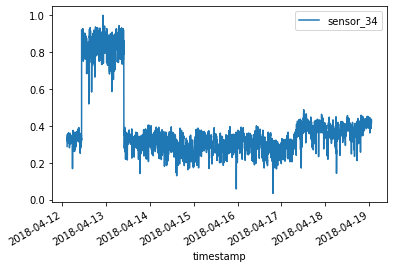

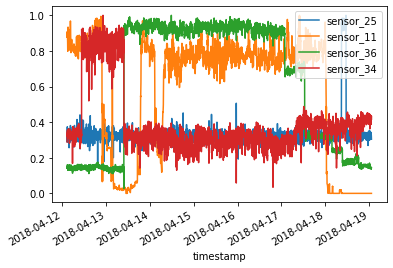

In [41]:
import matplotlib.pyplot as plt

# y='sensor_11'
# thin_data.plot(y='sensor_11')
thin_data.set_index("timestamp").plot(y="sensor_34")
thin_data.set_index("timestamp").plot()

<AxesSubplot:xlabel='timestamp'>

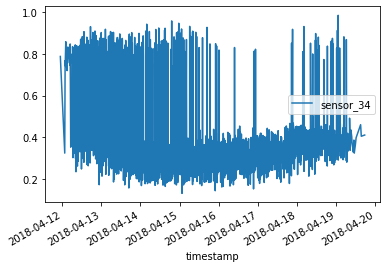

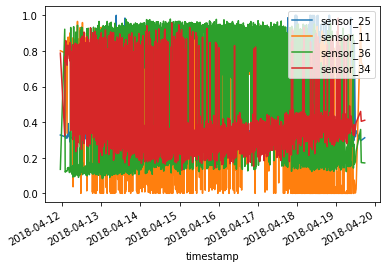

In [42]:
new_data.set_index("timestamp").plot(y="sensor_34")
new_data.set_index("timestamp").plot()
# new_data.plot(y='sensor_11')

In [43]:
dups_time = new_data.pivot_table(columns=["timestamp"], aggfunc="size")
print(dups_time.sort_values())

timestamp
2018-04-11 22:51:00    1
2018-04-16 12:46:00    1
2018-04-16 12:48:00    1
2018-04-16 12:50:00    1
2018-04-16 12:53:00    1
                      ..
2018-04-15 14:58:00    3
2018-04-13 10:33:00    3
2018-04-19 01:56:00    4
2018-04-14 20:40:00    4
2018-04-14 06:31:00    4
Length: 2575, dtype: int64


In [44]:
no_dups = new_data.groupby("timestamp").mean().reset_index()
no_dups

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34
0,2018-04-11 22:51:00,0.327788,0.800840,0.134905,0.787430
1,2018-04-12 01:33:00,0.318741,0.790407,0.922034,0.323914
2,2018-04-12 01:47:00,0.316429,0.807828,0.121319,0.767208
3,2018-04-12 01:49:00,0.331041,0.839155,0.119804,0.742752
4,2018-04-12 02:11:00,0.309846,0.812656,0.125951,0.858179
...,...,...,...,...,...
2570,2018-04-19 11:52:00,0.317812,0.001933,0.177346,0.363910
2571,2018-04-19 12:19:00,0.351588,0.024310,0.235691,0.397750
2572,2018-04-19 15:05:00,0.296301,0.959528,0.358858,0.460261
2573,2018-04-19 15:29:00,0.297770,0.734316,0.173068,0.404783


<AxesSubplot:xlabel='timestamp'>

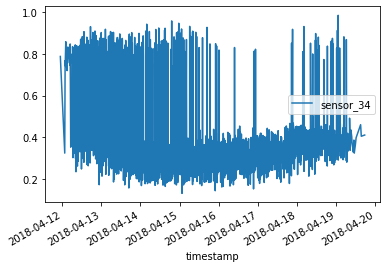

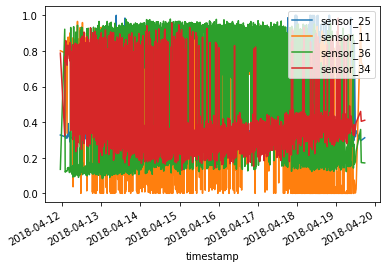

In [45]:
new_data.set_index("timestamp").plot(y="sensor_34")
new_data.set_index("timestamp").plot()

I tested this model with a wide variety of hyperparameters on Monday 7/11, with no luck. I think that it's safe to give up on SDV for our purposes. 